In [1]:
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer

In [3]:
url = "https://raw.githubusercontent.com/cmd1301/coffee_ML_prediction/main/datasets/arabica_data_cleaned.csv"

In [77]:
df = pd.read_csv(url)
df.head()

,Unnamed: 0,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,...,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,1,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,0,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
1,2,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,1,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
2,3,Arabica,grounds for health admin,Guatemala,"san marcos barrancas ""san cristobal cuch",NaN,NaN,NaN,NaN,1600 - 1800 m,...,NaN,0,"May 31st, 2011",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,1600.0,1800.0,1700.0
3,4,Arabica,yidnekachew dabessa,Ethiopia,yidnekachew dabessa coffee plantation,NaN,wolensu,NaN,yidnekachew debessa coffee plantation,1800-2200,...,Green,2,"March 25th, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1800.0,2200.0,2000.0
4,5,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,2,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0


In [5]:
def replace_dot_with_underscore(column_name):
    column_name = column_name.lower()
    return column_name.replace('.', '_')

df = df.rename(columns=replace_dot_with_underscore)
df.columns

Index(['unnamed: 0', 'species', 'owner', 'country_of_origin', 'farm_name',
       'lot_number', 'mill', 'ico_number', 'company', 'altitude', 'region',
       'producer', 'number_of_bags', 'bag_weight', 'in_country_partner',
       'harvest_year', 'grading_date', 'owner_1', 'variety',
       'processing_method', 'aroma', 'flavor', 'aftertaste', 'acidity', 'body',
       'balance', 'uniformity', 'clean_cup', 'sweetness', 'cupper_points',
       'total_cup_points', 'moisture', 'category_one_defects', 'quakers',
       'color', 'category_two_defects', 'expiration', 'certification_body',
       'certification_address', 'certification_contact', 'unit_of_measurement',
       'altitude_low_meters', 'altitude_high_meters', 'altitude_mean_meters'],
      dtype='object')

In [6]:
# Select the columns I'll be using for the analysis
cols = ['country_of_origin', 'region',
       'harvest_year', 'variety',
       'processing_method', 'total_cup_points',
       'altitude_mean_meters']

df2 = df[cols]

In [7]:
# DF shape
df2.shape

(1311, 7)

In [78]:
# Change the target column position
last_col = df2.pop('total_cup_points')
df2.insert(len(df2.columns), 'total_cup_points', last_col)
df2.head()

,country_of_origin,region,harvest_year,variety,processing_method,altitude_mean_meters,total_cup_points
1,ethiopia,guji-hambela,2014,other,washed-wet,2075.0,89.92
2,guatemala,NaN,NaN,bourbon,NaN,1700.0,89.75
4,ethiopia,guji-hambela,2014,other,washed-wet,2075.0,88.83
6,peru,NaN,2012,other,washed-wet,NaN,88.75
9,ethiopia,"snnp/kaffa zone,gimbowereda",2014,other,natural-dry,1822.5,88.25


In [9]:
# data types
df2.dtypes

country_of_origin        object
region                   object
harvest_year             object
variety                  object
processing_method        object
altitude_mean_meters    float64
total_cup_points        float64
dtype: object

In [10]:
# Verify presence of null and nan values:
df2.isna().sum()

country_of_origin         1
region                   57
harvest_year             47
variety                 201
processing_method       152
altitude_mean_meters    227
total_cup_points          0
dtype: int64

In [11]:
# Get to know a little bit further about the data, mainly if we have misspelled words, duplicates, wrong type of data, etc.
df2['region'].value_counts()

huila                              112
oriente                             80
south of minas                      68
kona                                66
veracruz                            35
                                  ... 
berastagi                            1
sapan toraja                         1
south huila                          1
mt elgon                             1
department d'artibonite , haiti      1
Name: region, Length: 343, dtype: int64

In [80]:
data = {"counts": df2['region'].dropna().value_counts()}
df_region_counts = pd.DataFrame(data, index = None)
df_region_counts

,counts
huila,91
oriente,78
south of minas,53
kona,43
veracruz,28
...,...
mahuixtlan,1
aceh,1
ikand village,1
moshi,1


In [13]:
# Uniform Harvest Year column

df2['harvest_year'].value_counts()

2012                        352
2014                        226
2013                        170
2015                        125
2016                        122
2017                         68
2013/2014                    29
2015/2016                    28
2011                         26
2017 / 2018                  19
2014/2015                    19
2009/2010                    12
2010                         10
2010-2011                     6
2016 / 2017                   6
4T/10                         4
March 2010                    3
2009-2010                     3
Mayo a Julio                  3
4T/2010                       3
Abril - Julio                 2
January 2011                  2
2011/2012                     2
08/09 crop                    2
December 2009-March 2010      1
TEST                          1
4T72010                       1
2018                          1
1t/2011                       1
2016/2017                     1
3T/2011                       1
Spring 2

In [14]:
df2['harvest_year'] = df2['harvest_year'].str.slice(0,4)
df2['harvest_year'].value_counts()

<ipython-input-14-0d9c29f8a8e3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['harvest_year'] = df2['harvest_year'].str.slice(0,4)


2012    352
2014    245
2013    199
2015    153
2016    129
2017     87
2011     28
2009     17
2010     16
4T/1      4
Abri      3
Mayo      3
4T/2      3
Janu      3
Marc      3
08/0      2
4t/2      2
47/2      1
4T72      1
2018      1
1t/2      1
3T/2      1
Spri      1
TEST      1
Dece      1
Augu      1
May-      1
1T/2      1
23 J      1
Fall      1
mmm       1
Sept      1
Name: harvest_year, dtype: int64

In [15]:
# define function to extract year as string of 4 digits
def extract_year(x):
    if isinstance(x, str):
        match = re.search(r'\d{4}', x)
        if match:
            return match.group()
    return np.nan

# apply function to the 'Harvest_Year' column
df2['harvest_year'] = df2['harvest_year'].apply(extract_year)

<ipython-input-15-098311397b80>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['harvest_year'] = df2['harvest_year'].apply(extract_year)


In [16]:
df2['harvest_year'].value_counts()

2012    352
2014    245
2013    199
2015    153
2016    129
2017     87
2011     28
2009     17
2010     16
2018      1
Name: harvest_year, dtype: int64

In [17]:
df2['processing_method'].value_counts()

Washed / Wet                 812
Natural / Dry                251
Semi-washed / Semi-pulped     56
Other                         26
Pulped natural / honey        14
Name: processing_method, dtype: int64

In [18]:
df2['processing_method'] = df2['processing_method'].str.lower().str.replace(" / ", "-")

<ipython-input-18-28218d1f9b9b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['processing_method'] = df2['processing_method'].str.lower().str.replace(" / ", "-")


In [19]:
df2['processing_method'].value_counts()

washed-wet                 812
natural-dry                251
semi-washed-semi-pulped     56
other                       26
pulped natural-honey        14
Name: processing_method, dtype: int64

In [20]:
df2['variety'].value_counts()

Caturra                  256
Bourbon                  226
Typica                   211
Other                    108
Catuai                    74
Hawaiian Kona             44
Yellow Bourbon            35
Mundo Novo                33
Catimor                   20
SL14                      17
SL28                      15
Pacas                     13
Gesha                     12
SL34                       8
Pacamara                   8
Arusha                     5
Peaberry                   5
Sumatra                    3
Mandheling                 3
Ruiru 11                   2
Blue Mountain              2
Ethiopian Yirgacheffe      2
Java                       2
Ethiopian Heirlooms        1
Moka Peaberry              1
Sulawesi                   1
Sumatra Lintong            1
Marigojipe                 1
Pache Comun                1
Name: variety, dtype: int64

In [21]:
df2['variety'] = df2['variety'].str.lower()

<ipython-input-21-9b4a9aef2d81>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['variety'] = df2['variety'].str.lower()


In [22]:
value_counts = df2['variety'].value_counts()

# Create a list of varieties with at least 10 counts
varieties_to_keep = value_counts[value_counts >= 10].index.tolist()

# Filter the DataFrame to keep only the rows with the selected varieties
df2 = df2[df2['variety'].isin(varieties_to_keep)]

In [23]:
df2['variety'].value_counts()

caturra           256
bourbon           226
typica            211
other             108
catuai             74
hawaiian kona      44
yellow bourbon     35
mundo novo         33
catimor            20
sl14               17
sl28               15
pacas              13
gesha              12
Name: variety, dtype: int64

In [24]:
df2['country_of_origin'].value_counts()

Mexico                          222
Guatemala                       171
Colombia                        140
Brazil                          112
Taiwan                           68
Honduras                         50
Costa Rica                       45
United States (Hawaii)           44
Tanzania, United Republic Of     35
Uganda                           25
El Salvador                      17
China                            16
Nicaragua                        15
Kenya                            14
Ethiopia                         12
Thailand                         11
Malawi                           11
Indonesia                         8
Myanmar                           8
United States                     7
Vietnam                           7
United States (Puerto Rico)       4
Haiti                             4
Philippines                       4
Panama                            4
Peru                              3
Laos                              3
Japan                       

In [25]:
df2['country_of_origin'] = df2['country_of_origin'].str.lower()

In [26]:
df2['country_of_origin'].value_counts()

mexico                          222
guatemala                       171
colombia                        140
brazil                          112
taiwan                           68
honduras                         50
costa rica                       45
united states (hawaii)           44
tanzania, united republic of     35
uganda                           25
el salvador                      17
china                            16
nicaragua                        15
kenya                            14
ethiopia                         12
thailand                         11
malawi                           11
indonesia                         8
myanmar                           8
united states                     7
vietnam                           7
united states (puerto rico)       4
haiti                             4
philippines                       4
panama                            4
peru                              3
laos                              3
japan                       

In [81]:
import plotly.express as px

country_value_counts = df2['country_of_origin'].value_counts().reset_index()
country_value_counts.columns = ['country_of_origin', 'Value_Counts']

# Plot the map graph
fig = px.choropleth(country_value_counts, locations='country_of_origin', locationmode="country names", color='Value_Counts')
fig.update_layout(title='Map Graph with Colored Countrys')
fig.show()


In [82]:
# Here we can see the main statistics for numeric data, extreme high altitudes and values = "0" in total cup points are unusual
df2.describe()

,altitude_mean_meters,total_cup_points
count,923.000000,1029.000000
mean,1358.495508,82.046929
std,421.259394,2.681054
min,200.000000,59.830000
25%,1147.000000,81.080000
50%,1310.640000,82.420000
75%,1600.000000,83.580000
max,4287.000000,89.920000


In [29]:
# Looking for outliers values in total cup points

df2['total_cup_points'].value_counts()

83.17    31
83.00    29
82.75    27
82.33    26
82.42    24
         ..
77.17     1
77.00     1
76.75     1
76.50     1
0.00      1
Name: total_cup_points, Length: 156, dtype: int64

In [30]:
def outliers(list_values):
  Q1 = list_values.quantile(0.25)
  Q3 = list_values.quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5*IQR
  upper_bound = Q3 + 1.5*IQR

  outliers = []
  for value in list_values:
    if value < lower_bound:
      outliers.append(value)
    elif value > upper_bound:
      outliers.append(value)
    else:
      continue
  return len(outliers)

In [31]:
list_x = df2['total_cup_points']
outliers(list_x)

61

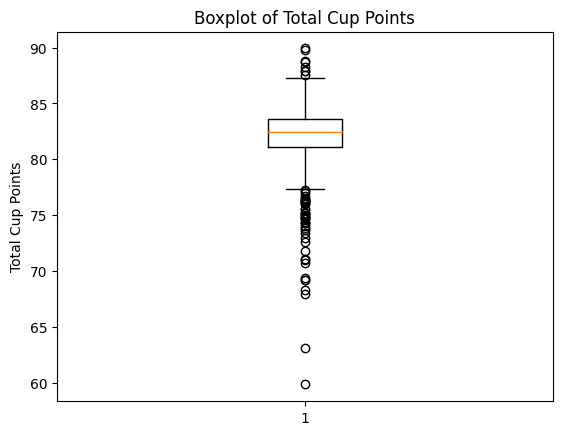

In [83]:
plt.boxplot(df2['total_cup_points'], showfliers=True, whis=1.5)

# Set title and axis labels
plt.title('Boxplot of Total Cup Points')
plt.ylabel('Total Cup Points')

# Display plot
plt.show()

It has been decided that the only outlier is the value 0. Other values are acceptable to the analysis.

In [33]:
df2 = df2.drop(df2[df2['total_cup_points'] == 0].index)
df2['total_cup_points'].value_counts()

83.17    31
83.00    29
82.75    27
82.33    26
81.83    24
         ..
77.17     1
77.00     1
76.75     1
76.50     1
59.83     1
Name: total_cup_points, Length: 155, dtype: int64

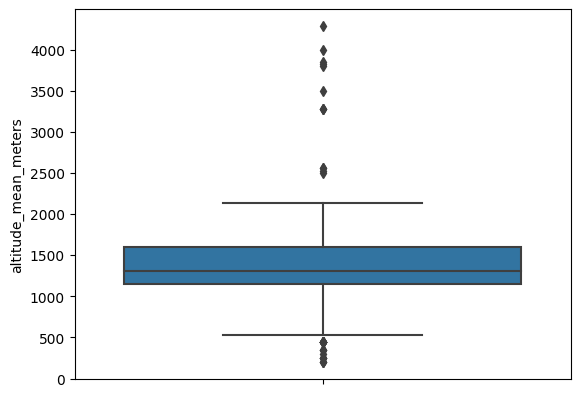

In [84]:
# Looking for outliers in altitude

sns.boxplot(data= df2, y= "altitude_mean_meters")

plt.show()

In [35]:
df2 = df2.drop(df2[(df2['altitude_mean_meters'] > 10000)].index)
df2 = df2.drop(df2[(df2['altitude_mean_meters'] < 200)].index)

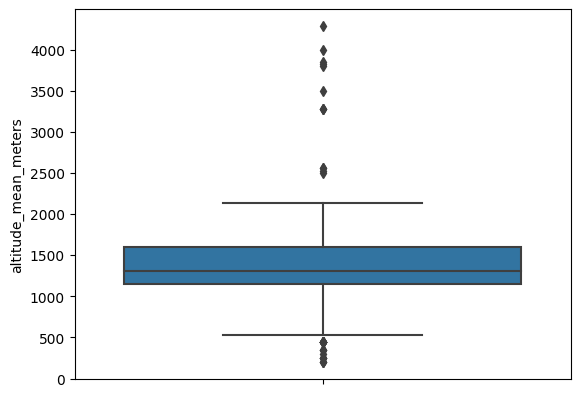

In [85]:
sns.boxplot(data= df2, y= "altitude_mean_meters")

plt.show()

In [37]:
df2.shape

(1029, 7)

In [38]:
df2.to_csv('/content/drive/MyDrive/Colab Notebooks/coffee_ml.csv', index=False)

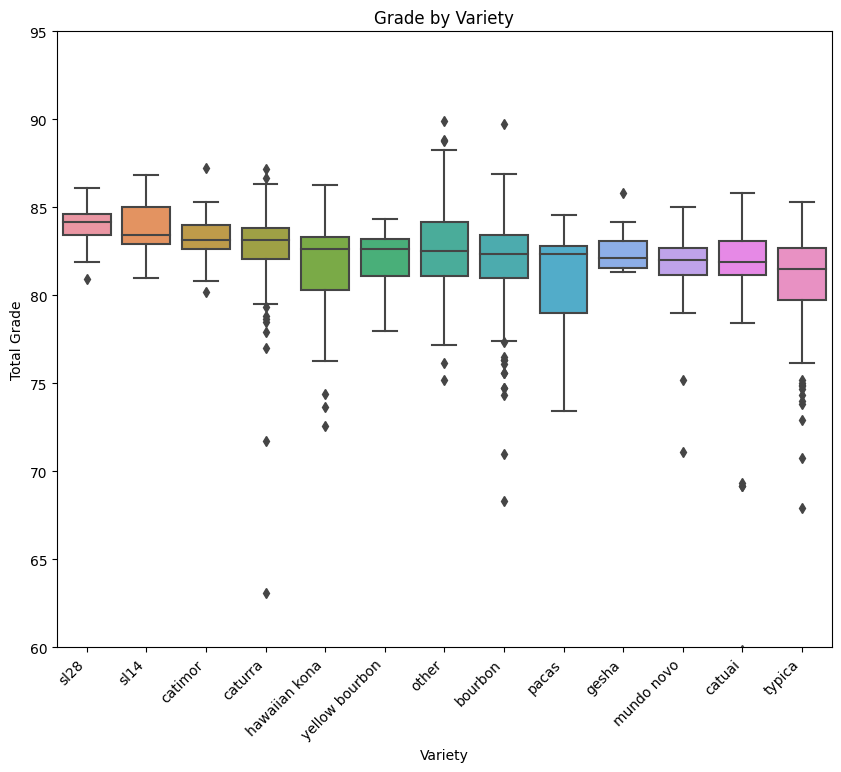

In [86]:
grouped_grade_variety = df2.loc[:,['variety', 'total_cup_points']].groupby('variety').median().sort_values(by='total_cup_points', ascending=False)

plt.figure(figsize=[10,8], facecolor='white')
sns.boxplot(x='variety', y='total_cup_points',data=df2, order=grouped_grade_variety.index)
plt.title('Grade by Variety')
plt.xlabel('Variety')
plt.xticks(rotation = 45, ha='right')
plt.ylabel('Total Grade')
plt.ylim(60, 95)
plt.savefig('grade_by_variety.png')

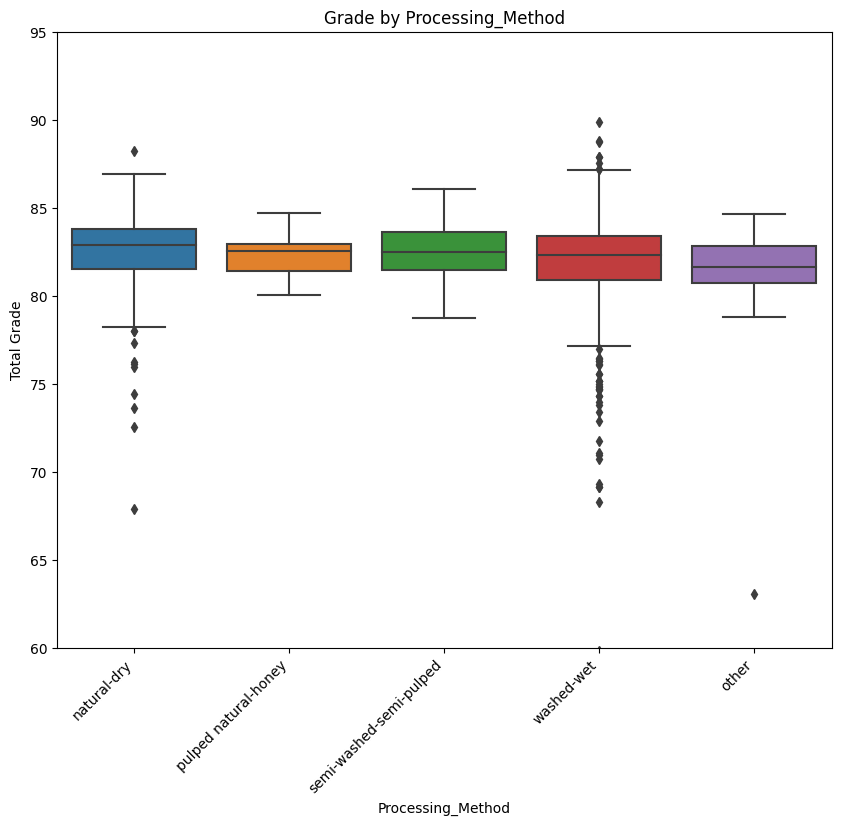

In [87]:
grouped_grade_processing = df2.loc[:,['processing_method', 'total_cup_points']].groupby('processing_method').median().sort_values(by='total_cup_points', ascending=False)

plt.figure(figsize=[10,8], facecolor='white')
sns.boxplot(x='processing_method', y='total_cup_points',data=df2, order=grouped_grade_processing.index)
plt.title('Grade by Processing_Method')
plt.xlabel('Processing_Method')
plt.xticks(rotation = 45, ha='right')
plt.ylabel('Total Grade')
plt.ylim(60, 95)
plt.savefig('grade_by_Processing_Method.png')

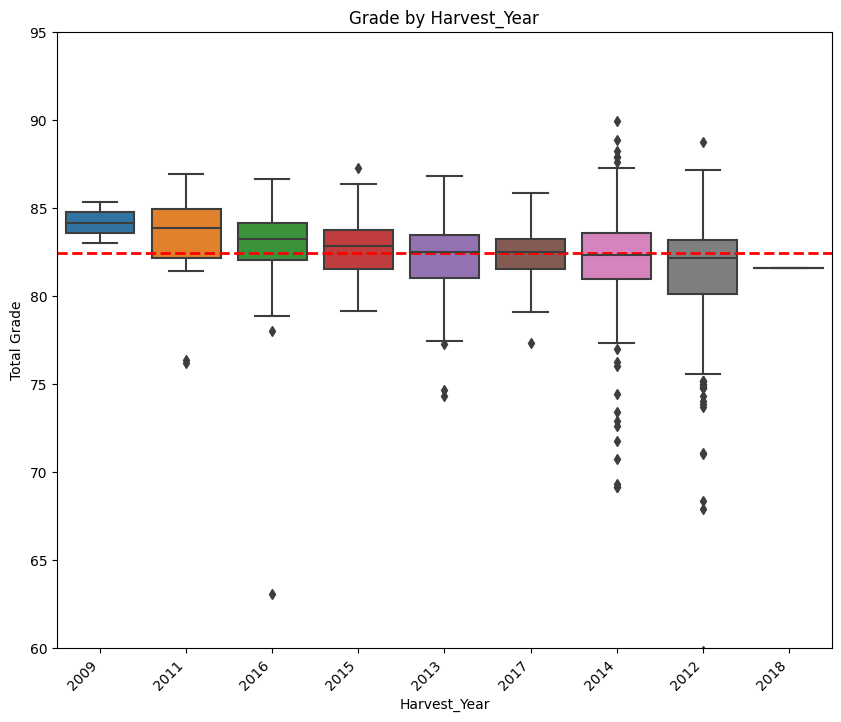

In [88]:
grouped_grade_harvest = df2.loc[:,['harvest_year', 'total_cup_points']].groupby('harvest_year').median().sort_values(by='total_cup_points', ascending=False)

plt.figure(figsize=[10,8], facecolor='white')
sns.boxplot(x='harvest_year', y='total_cup_points',data=df2, order=grouped_grade_harvest.index)
plt.title('Grade by Harvest_Year')
plt.xlabel('Harvest_Year')
plt.xticks(rotation = 45, ha='right')
plt.ylabel('Total Grade')
plt.ylim(60, 95)
overall_median = np.median(df2['total_cup_points'])
plt.axhline(overall_median, color='red', linestyle='--', linewidth=2)
plt.savefig('grade_by_Harvest_Year.png')

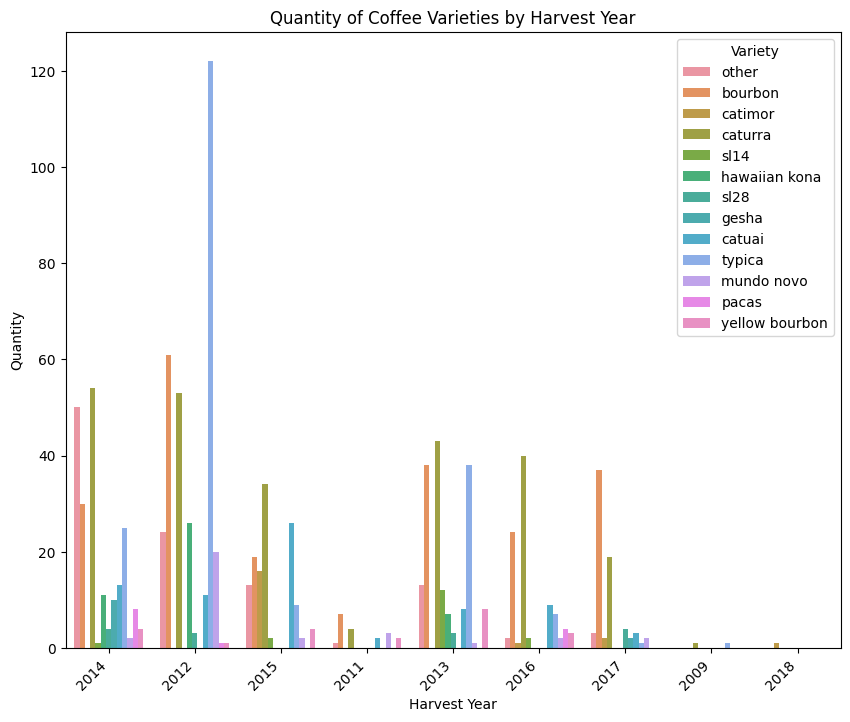

In [89]:
plt.figure(figsize=[10, 8], facecolor='white')
sns.countplot(x='harvest_year', hue='variety', data=df2)
plt.title('Quantity of Coffee Varieties by Harvest Year')
plt.xlabel('Harvest Year')
plt.ylabel('Quantity')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Variety')
plt.savefig('coffee_variety_by_harvest_year.png')

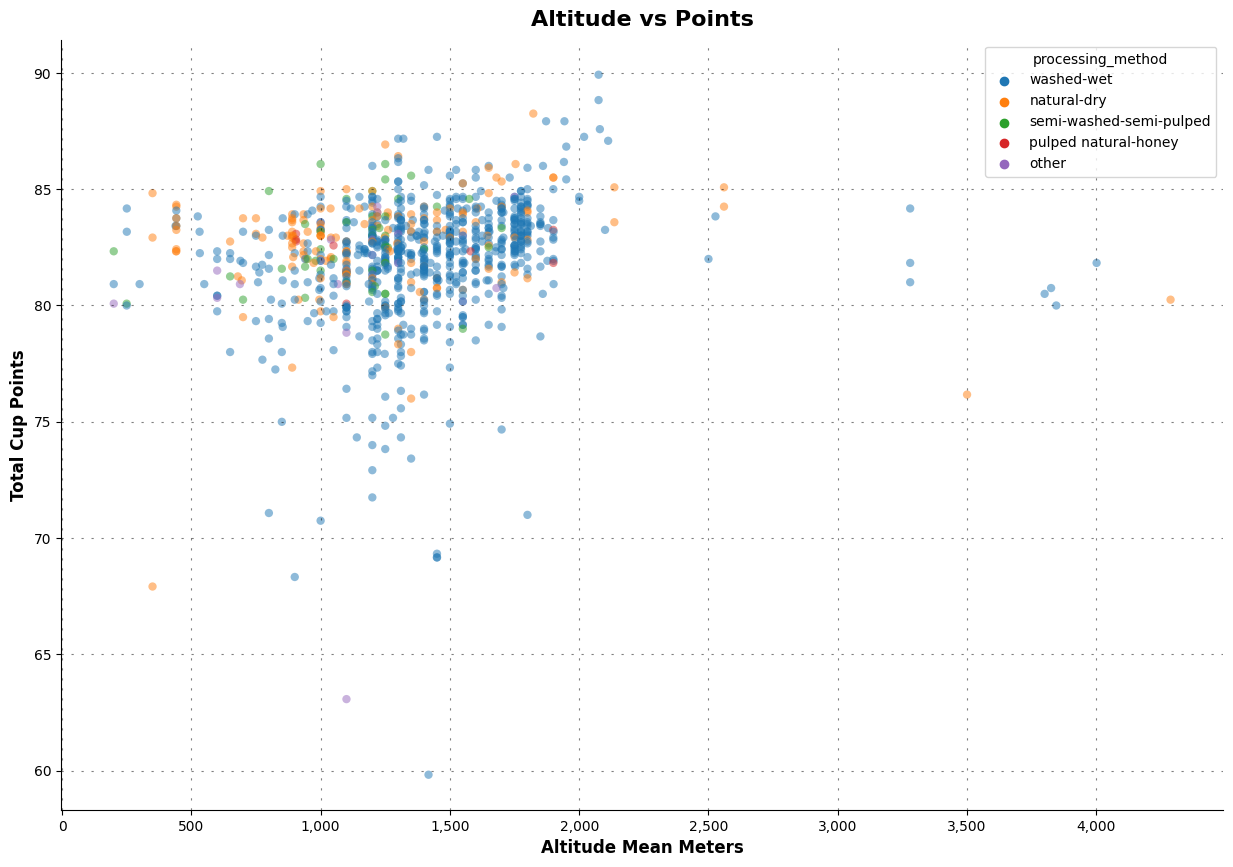

In [90]:
plt.figure(figsize= (15, 10))
plt.grid(which='both', color='black', linestyle='--', dashes=(2,7), alpha= 0.5, zorder= 0)

ax= sns.scatterplot(data= df2, x= "altitude_mean_meters", y= "total_cup_points", hue= "processing_method",
                   alpha= 0.5, linewidth=0, palette= "tab10")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

import matplotlib.ticker as tkr
ax.get_xaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.title("Altitude vs Points", fontsize= 16, fontweight= "bold", pad= 10)
plt.ylabel(ax.yaxis.get_label().get_text().title().replace("_", " "), fontsize= 12, fontweight= "bold")
plt.xlabel(ax.xaxis.get_label().get_text().title().replace("_", " "), fontsize= 12, fontweight= "bold")
plt.show()

(60.0, 95.0)

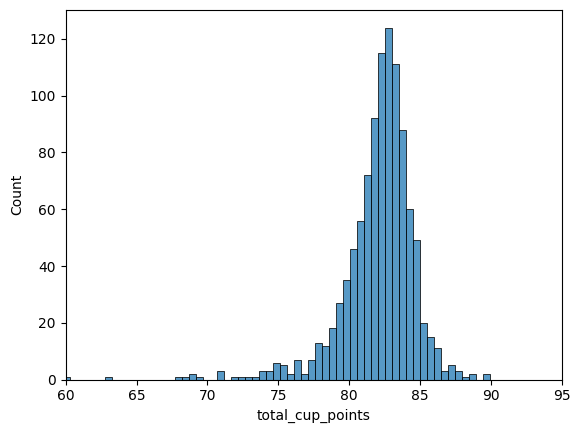

In [91]:
sns.histplot(df2['total_cup_points'])
plt.xlim(60, 95)

## MACHINE LEARNING

I will keep altitudes values as float for now

Now, I will prepare de data to implement the ML algorithm with data split

For the pipeline I must:
- implement SimpleImputer OK!
- scaler
- implement One Hot Encoder
- implement ML algorithm

The algorithm choice:
- Regression
- DecisionTree
- RandomForest
- SVR
- xgboost

In [46]:
X = df2.drop('total_cup_points', axis=1)
y = df2['total_cup_points']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [48]:
# Define the function that will aplly the pipeline and the machine learning algorithm in the data and return the main metrics

def pipeline_creator(ml_model):

  categorical_cols = ['country_of_origin', 'region', 'variety', 'processing_method']
  numerical_cols = ['harvest_year', 'altitude_mean_meters']

  pipeline = Pipeline([
      ('preprocessor', ColumnTransformer(
          transformers=[
              ('num', Pipeline([
                  ('imputer', SimpleImputer(strategy='mean')),
                  ('scaler', StandardScaler())
              ]), numerical_cols),
              ('cat', Pipeline([
                  ('imputer', SimpleImputer(strategy='most_frequent')),
                  ('encoder', OneHotEncoder(handle_unknown='ignore'))
              ]), categorical_cols)
          ]
      )),
      ('regressor', ml_model)
  ])

  return pipeline

def fit_pred(pipeline, ml_name):
  pipeline.fit(X_train, y_train)

  y_pred = pipeline.predict(X_test)

  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  r2 = r2_score(y_test, y_pred)
  y_test_mean= y_test.mean()
  mae_ratio= mae/y_test_mean
  rmse_ratio= rmse/y_test_mean
    
  result_df = pd.DataFrame(
      data=[[ml_name, mae, mse, rmse, r2, mae_ratio, rmse_ratio]], 
      columns=["Model", 'MAE', 'MSE', 'RMSE', 'R2 Score', "MAE Ratio", "RMSE Ratio"])
  return result_df

def pred_tunned(pipeline, ml_name):
  
  y_pred = pipeline.predict(X_test)

  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  r2 = r2_score(y_test, y_pred)
  y_test_mean= y_test.mean()
  mae_ratio= mae/y_test_mean
  rmse_ratio= rmse/y_test_mean
    
  result_df = pd.DataFrame(
      data=[[ml_name, mae, mse, rmse, r2, mae_ratio, rmse_ratio]], 
      columns=["Model", 'MAE', 'MSE', 'RMSE', 'R2 Score', "MAE Ratio", "RMSE Ratio"])
  return result_df

In [50]:
gxr = 'GBoostRegressor'
gxr_model = GradientBoostingRegressor()

pipe = pipeline_creator(gxr_model)
result_df = fit_pred(pipe, gxr)
result_df

,Model,MAE,MSE,RMSE,R2 Score,MAE Ratio,RMSE Ratio
0,GBoostRegressor,1.660215,5.946731,2.438592,0.147871,0.020208,0.029682


In [51]:
rfr = 'RFRegressor'
rfr_model = RandomForestRegressor()

pipe = pipeline_creator(rfr_model)
result_df_2 = fit_pred(pipe, rfr)
result_df = result_df.append(result_df_2, ignore_index=True)
result_df= result_df.sort_values("RMSE Ratio", ignore_index= True)
result_df

<ipython-input-51-c7712f08cf8d>:6: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Model,MAE,MSE,RMSE,R2 Score,MAE Ratio,RMSE Ratio
0,RFRegressor,1.587860,5.638216,2.374493,0.192080,0.019327,0.028902
1,GBoostRegressor,1.660215,5.946731,2.438592,0.147871,0.020208,0.029682


In [52]:
from sklearn.linear_model import LinearRegression

LR = 'LR'
LR_model = LinearRegression()

pipe = pipeline_creator(LR_model)
result_df_2 = fit_pred(pipe, LR)
result_df = result_df.append(result_df_2, ignore_index=True)
result_df= result_df.sort_values("RMSE Ratio", ignore_index= True)
result_df

<ipython-input-52-1499397513ac>:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Model,MAE,MSE,RMSE,R2 Score,MAE Ratio,RMSE Ratio
0,RFRegressor,1.587860,5.638216,2.374493,0.192080,0.019327,0.028902
1,GBoostRegressor,1.660215,5.946731,2.438592,0.147871,0.020208,0.029682
2,LR,2.169479,11.297397,3.361160,-0.618845,0.026406,0.040911


In [53]:
from sklearn.tree import DecisionTreeRegressor

dtr = 'DTRegressor'
dtr_model = DecisionTreeRegressor()

pipe = pipeline_creator(dtr_model)
result_df_2 = fit_pred(pipe, dtr)
result_df = result_df.append(result_df_2, ignore_index=True)
result_df= result_df.sort_values("RMSE Ratio", ignore_index= True)
result_df

<ipython-input-53-e3f0c1674750>:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Model,MAE,MSE,RMSE,R2 Score,MAE Ratio,RMSE Ratio
0,RFRegressor,1.587860,5.638216,2.374493,0.192080,0.019327,0.028902
1,GBoostRegressor,1.660215,5.946731,2.438592,0.147871,0.020208,0.029682
2,DTRegressor,1.763117,6.675385,2.583677,0.043460,0.021460,0.031448
3,LR,2.169479,11.297397,3.361160,-0.618845,0.026406,0.040911


In [54]:
from sklearn.svm import SVR

svr = 'SVR'
svr_model = SVR()

pipe = pipeline_creator(svr_model)
result_df_2 = fit_pred(pipe, svr)
result_df = result_df.append(result_df_2, ignore_index=True)
result_df= result_df.sort_values("RMSE Ratio", ignore_index= True)
result_df

<ipython-input-54-5c2d15a70ccb>:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Model,MAE,MSE,RMSE,R2 Score,MAE Ratio,RMSE Ratio
0,RFRegressor,1.587860,5.638216,2.374493,0.192080,0.019327,0.028902
1,GBoostRegressor,1.660215,5.946731,2.438592,0.147871,0.020208,0.029682
2,SVR,1.568788,5.961638,2.441647,0.145735,0.019095,0.029719
3,DTRegressor,1.763117,6.675385,2.583677,0.043460,0.021460,0.031448
4,LR,2.169479,11.297397,3.361160,-0.618845,0.026406,0.040911


In [55]:
result_df

,Model,MAE,MSE,RMSE,R2 Score,MAE Ratio,RMSE Ratio
0,RFRegressor,1.587860,5.638216,2.374493,0.192080,0.019327,0.028902
1,GBoostRegressor,1.660215,5.946731,2.438592,0.147871,0.020208,0.029682
2,SVR,1.568788,5.961638,2.441647,0.145735,0.019095,0.029719
3,DTRegressor,1.763117,6.675385,2.583677,0.043460,0.021460,0.031448
4,LR,2.169479,11.297397,3.361160,-0.618845,0.026406,0.040911


In [56]:
from sklearn.model_selection import KFold, GridSearchCV

svr_model = SVR()
pipe = pipeline_creator(svr_model)

splitter = KFold(n_splits=5, shuffle=True, random_state=42)

svr_params = {"regressor__kernel": ["linear", "poly", "rbf"],
              "regressor__degree": [1, 2, 3],
              "regressor__C": [0.1, 1, 2],
              "regressor__epsilon": [0.1, 0.5, 1, 2]}

svr_grid = GridSearchCV(estimator=pipe, param_grid=svr_params, cv=splitter)

svr_grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['harvest_year',
                                                                          'altitude_mean_meters']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['country_of_origin',
                                                                          'region',
                                                                          'variety',
                                                                          'processing_method'])])),
                                       ('regressor', SVR())]),
             param_grid={'regressor__C': [0.1, 1, 2],
                         'regressor__degree': [1, 2, 3],
                         'regressor__epsilon': [0.1, 0.5, 1, 2],
                         'regressor__kernel': ['linear', 'poly', 'rbf']})

In [57]:
svr_grid.best_params_

{'regressor__C': 2,
 'regressor__degree': 1,
 'regressor__epsilon': 1,
 'regressor__kernel': 'rbf'}

In [58]:
ml_name = "SVR_tunned"
result_df_2= pred_tunned(svr_grid, ml_name)
result_df = result_df.append(result_df_2, ignore_index=True)
result_df= result_df.sort_values("RMSE Ratio", ignore_index= True)
result_df

<ipython-input-58-a93b97c40355>:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Model,MAE,MSE,RMSE,R2 Score,MAE Ratio,RMSE Ratio
0,RFRegressor,1.587860,5.638216,2.374493,0.192080,0.019327,0.028902
1,GBoostRegressor,1.660215,5.946731,2.438592,0.147871,0.020208,0.029682
2,SVR,1.568788,5.961638,2.441647,0.145735,0.019095,0.029719
3,SVR_tunned,1.617381,6.085859,2.466953,0.127935,0.019686,0.030027
4,DTRegressor,1.763117,6.675385,2.583677,0.043460,0.021460,0.031448
5,LR,2.169479,11.297397,3.361160,-0.618845,0.026406,0.040911


In [59]:
rfr_model = RandomForestRegressor()
pipe = pipeline_creator(rfr_model)

splitter = KFold(n_splits=5, shuffle=True, random_state=42)

rfr_params = {"regressor__n_estimators": list(range(80, 160, 20)),
              "regressor__max_depth": list(range(2, 11, 2)),
              "regressor__min_samples_leaf": list(range(1, 3)),
              "regressor__random_state": [42]}

rfr_grid = GridSearchCV(estimator=pipe, param_grid=rfr_params, cv=splitter)

rfr_grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['harvest_year',
                                                                          'altitude_mean_meters']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['country_of_origin',
                                                                          'region',
                                                                          'variety',
                                                                          'processing_method'])])),
                                       ('regressor', RandomForestRegressor())]),
             param_grid={'regressor__max_depth': [2, 4, 6, 8, 10],
                         'regressor__min_samples_leaf': [1, 2],
                         'regressor__n_estimators': [80, 100, 120, 140],
                         'regressor__random_state': [42]})

In [60]:
rfr_grid.best_params_

{'regressor__max_depth': 10,
 'regressor__min_samples_leaf': 2,
 'regressor__n_estimators': 120,
 'regressor__random_state': 42}

In [61]:
ml_name = "RFRegressor_tunned"
result_df_2= pred_tunned(rfr_grid, ml_name)
result_df = result_df.append(result_df_2, ignore_index=True)
result_df= result_df.sort_values("RMSE Ratio", ignore_index= True)
result_df

<ipython-input-61-2d50af0bf0a7>:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Model,MAE,MSE,RMSE,R2 Score,MAE Ratio,RMSE Ratio
0,RFRegressor_tunned,1.574183,5.505581,2.346397,0.211085,0.019161,0.028560
1,RFRegressor,1.587860,5.638216,2.374493,0.192080,0.019327,0.028902
2,GBoostRegressor,1.660215,5.946731,2.438592,0.147871,0.020208,0.029682
3,SVR,1.568788,5.961638,2.441647,0.145735,0.019095,0.029719
4,SVR_tunned,1.617381,6.085859,2.466953,0.127935,0.019686,0.030027
5,DTRegressor,1.763117,6.675385,2.583677,0.043460,0.021460,0.031448
6,LR,2.169479,11.297397,3.361160,-0.618845,0.026406,0.040911


In [62]:
result_df

,Model,MAE,MSE,RMSE,R2 Score,MAE Ratio,RMSE Ratio
0,RFRegressor_tunned,1.574183,5.505581,2.346397,0.211085,0.019161,0.028560
1,RFRegressor,1.587860,5.638216,2.374493,0.192080,0.019327,0.028902
2,GBoostRegressor,1.660215,5.946731,2.438592,0.147871,0.020208,0.029682
3,SVR,1.568788,5.961638,2.441647,0.145735,0.019095,0.029719
4,SVR_tunned,1.617381,6.085859,2.466953,0.127935,0.019686,0.030027
5,DTRegressor,1.763117,6.675385,2.583677,0.043460,0.021460,0.031448
6,LR,2.169479,11.297397,3.361160,-0.618845,0.026406,0.040911


In [75]:
# define o endpoint para a previsão
def predict(country: str, region: str, harvest_year: float, variety: str, processing_method: str, altitude_mean: float):

    # transforma a entrada em um array numpy
    data = {'country_of_origin': [country.lower()],
            'region': [region.lower()],
            'harvest_year': [harvest_year],
            'variety': [variety.lower()],
            'processing_method': [processing_method.lower()],
            'altitude_mean_meters': [altitude_mean]}
    dfx = pd.DataFrame(data)

     # Verifica se os valores estão contidos no banco de dados
    if not dfx['country_of_origin'].isin(df2['country_of_origin']).any() \
            or not dfx['region'].isin(df2['region']).any() \
            or not dfx['variety'].isin(df2['variety']).any() \
            or not dfx['processing_method'].isin(df2['processing_method']).any():
        raise ValueError('Error: Input values not found in the database.')

    # faz a previsão usando o modelo treinado
    prediction = rfr_grid.predict(dfx)[0]

    # retorna a espécie prevista como uma resposta da API
    return {"total_cup_points": prediction}

In [79]:
predict("ethiopia", "guji-hambela", 2014, "other", "Washed-wet", 2075)

{'total_cup_points': 86.3660374737189}